In [1]:
#Connect to your google drive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
#checking the available files
%cd /gdrive/My\ Drive/digit-recognizer
!ls -ltr

/gdrive/My Drive/digit-recognizer
total 125132
-rw------- 1 root root 51118296 Dec 11  2019 test.csv
-rw------- 1 root root   240909 Dec 11  2019 sample_submission.csv
-rw------- 1 root root 76775041 Dec 11  2019 train.csv


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import seaborn as sns
import random

from tqdm import tqdm

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from random import randint

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
#from pactools.grid_search import GridSearchCVProgressBar

from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [5]:
#%%timeit -n 10
# 10 loops, best of 3: 7.07 s per loop
mnist_train = pd.read_csv("train.csv")
mnist_test  = pd.read_csv("test.csv")

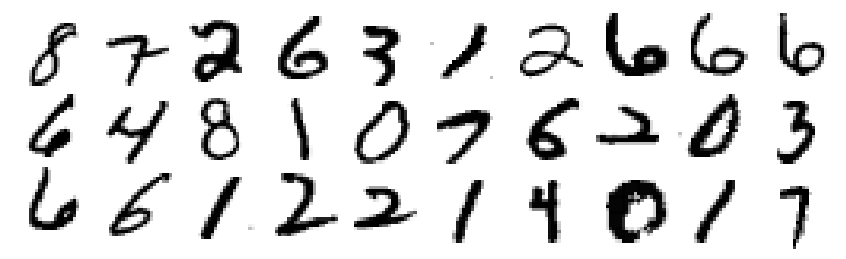

In [6]:
# VISUALIZE DATA
samples = mnist_train.iloc[5000:5030,1:].values
plt.figure(figsize=(15,4.5))
for i in range(30):  
    plt.subplot(3, 10, i+1)
    plt.imshow(samples[i].reshape((28,28)),cmap=plt.cm.binary)
    plt.axis('off')
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

In [7]:
mnist_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
print(mnist_train.shape, mnist_test.shape)

(42000, 785) (28000, 784)


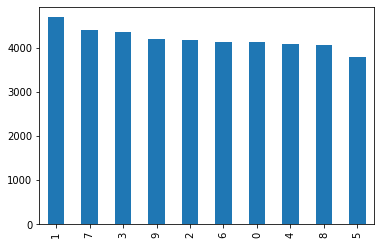

In [9]:
#%%timeit
#345 ms
_ = mnist_train['label'].value_counts().plot(kind='bar')
plt.show()

In [10]:
#%%time
#Wall time: 14.6 s
X_raw = mnist_train.drop(['label'], axis = 1, inplace = False)
y = mnist_train['label']

In [11]:
#Data is being Scaled now to make it uniform
#%%time
# Wall time: 28.5 s
arr = X_raw.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(arr)
X = pd.DataFrame(x_scaled)

X.max()

In [13]:
# %%timeit -n 3
# 3 loops, best of 3: 1.66 s per loop
pca = PCA(n_components = 2)
principal_components = pca.fit_transform(X)
principal_DF = pd.DataFrame(data = principal_components, columns = ['component1', 'component2'])
final_DF = pd.concat( [principal_DF, mnist_train[['label']]], axis = 1)

['#10AEFD', '#DB9758', '#F71252', '#07981E', '#6985B5', '#ECD75A', '#FB8B34', '#8E1730', '#52099B', '#119D58']


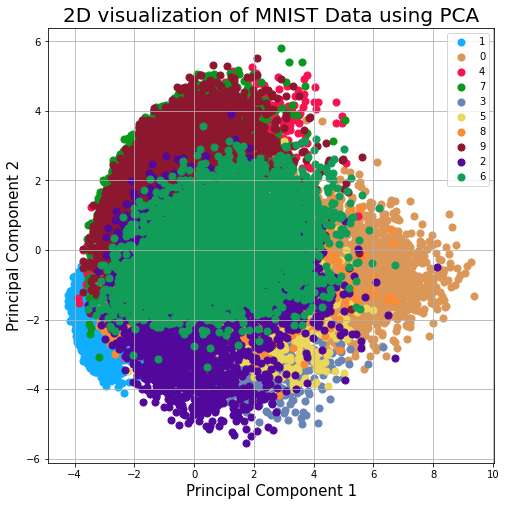

In [14]:
fig = plt.figure(figsize = (8,8))
ax = plt.subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2D visualization of MNIST Data using PCA', fontsize = 20)

targets = list(mnist_train['label'].unique())
random.seed(10)
colors = []
for i in range(10):
    colors.append('#%06X' % randint(0, 0xFFFFFF))
print(colors)
for target, color in zip(targets,colors):
    indicesToKeep = final_DF['label'] == target
    ax.scatter(final_DF.loc[indicesToKeep, 'component1'], final_DF.loc[indicesToKeep,'component2'], c = color, s=50)
ax.legend(targets)
ax.grid()


In [15]:
X_1, X_test, y_1, y_test = train_test_split(X,y,test_size = 0.25, random_state = 10)
X_train, X_cv, y_train, y_cv = train_test_split(X_1,y_1,test_size = 0.20, random_state = 10)
print(X_train.shape, X_test.shape, X_cv. shape, y_train.shape, y_test.shape, y_cv.shape)

(25200, 784) (10500, 784) (6300, 784) (25200,) (10500,) (6300,)


In [16]:
def trainKNN(X_train, y_train, k): 
    """Function to train model using KNN classifier
    Takes argumenst as training dataset, k-value and returns classifier
    """
    classifier = KNeighborsClassifier(n_neighbors=k, n_jobs = -1)
    classifier.fit(X_train,y_train)
    return classifier

In [17]:
def predictClassifier(X_test, classifier):
    """Function to predict labels using classifier
       Takes argumenst as test/cv dataset, and returns predicted values by model
    """
    y_pred = classifier.predict(X_test)
    return y_pred

In [18]:
def calculateAccuracy(y_pred, y_test):
    """Function to check accuracy of the model. Takes input arguments as actual and predicted values
       and returns accuracy score
    """
    accuracy = accuracy_score(y_pred, y_test)
    return accuracy

In [19]:
#%%time
# Wall time: 17min 52s
kvalues = [x for x in range(1,50, 6)]
AccuracyList = []
for k in tqdm(kvalues):
    knnClassifier = trainKNN(X_train, y_train, k)
    y_pred = predictClassifier(X_cv, knnClassifier)
    acc = calculateAccuracy(y_pred, y_cv)
    AccuracyList.append(acc)     

100%|██████████| 9/9 [01:08<00:00,  7.58s/it]


In [20]:
AccuracyList

[0.9633333333333334,
 0.9652380952380952,
 0.9611111111111111,
 0.9568253968253968,
 0.9552380952380952,
 0.9517460317460318,
 0.9480952380952381,
 0.9457142857142857,
 0.9442857142857143]

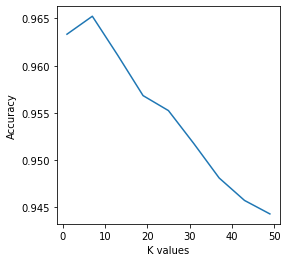

In [21]:
f = plt.figure(figsize = (4,4))
ax = plt.subplot()
plt.plot(kvalues,AccuracyList)
ax.set_xlabel('K values', fontsize = 10)
ax.set_ylabel('Accuracy', fontsize = 10)
plt.show()

In [22]:
#%%time
# Wall time: 3min 49s
clf = trainKNN(X_train,y_train, 7)
y_pred = predictClassifier(X_test, knnClassifier)
acc = calculateAccuracy(y_pred, y_test)
print("Final Accuracy: ",acc)

Final Accuracy:  0.9407619047619048


################# Confusion Matrix ####################


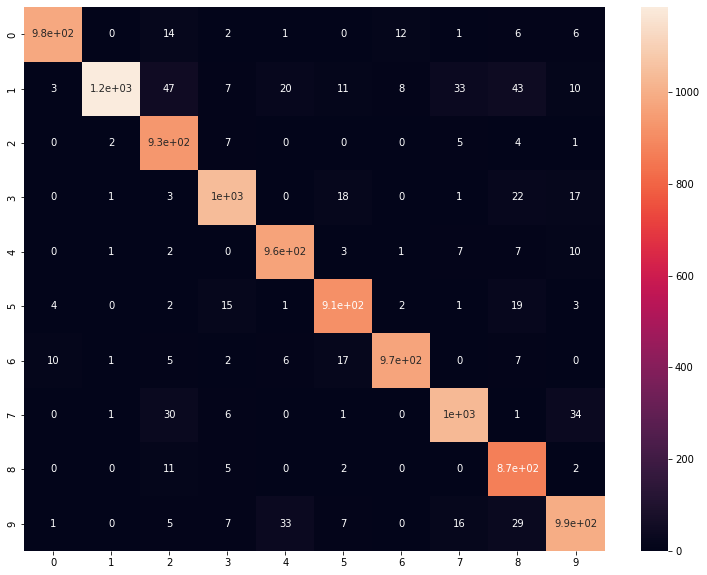

In [23]:
num_digits= np.unique(y)
cf = confusion_matrix(y_pred,y_test, labels = num_digits )
print("################# Confusion Matrix ####################")
fig = plt.figure(figsize = (13,10))
ax= plt.subplot()
sns.heatmap(cf, annot=True, ax = ax); #annot=True to annotate cells


In [25]:
[]

[]